In [1]:
import dgl

from Coarsener.HeteroRGCNCoarsener import HeteroRGCNCoarsener
from Data.Citeseer import Citeseer
import dgl.function as fn

import torch
import numpy as np

torch.cuda.empty_cache()


/home/robin/thesis/hetero-conv-matching/.venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = Citeseer() 

original_graph = dataset.load_graph(n_components = 10)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
original_graph = original_graph.to(device=device)
print(device)
dataset2 = Citeseer()
original_graph_2 = dataset2.load_graph(n_components = None)
original_graph_2 = original_graph_2.to(device=device)


  NumNodes: 3327
  NumEdges: 9228
  NumFeats: 3703
  NumClasses: 6
  NumTrainingSamples: 120
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.
cuda:0
  NumNodes: 3327
  NumEdges: 9228
  NumFeats: 3703
  NumClasses: 6
  NumTrainingSamples: 120
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


In [4]:
#original_graph = dataset.load_graph(n_components = 50)
from Projections.JLRandom import JLRandomProjection
original_graph = original_graph.to(device=device)
from Projections.CCA import CCA
from Projections.ContrastiveLearner import LinearContrastiveLearner

num_nearest_init_neighbors_per_type = {"paper": 1, "cites": 25, "cited-by":1}
coarsener = HeteroRGCNCoarsener(original_graph, num_nearest_init_neighbors_per_type,initial_k_layer=2, device=device, pairs_per_level=10,norm_p=1, approx_neigh=True, 
                                 use_out_degree=True, use_zscore=False, cca_cls=LinearContrastiveLearner , add_feat=True , use_cos_sim=False,folder_name="cit_cl_linear_pca_10" , checkpoints=[0.99, 0.9, 0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1]          ) # , projection_cls= JLRandomProjection
#, batch_size=4096
coarsener.init()
coarsener.summarize()

#original_graph = dataset.load_graph(n_components = 50)
from Projections.JLRandom import JLRandomProjection
# original_graph = original_graph.to(device=device)
# from Projections.CCA import CCA

# num_nearest_init_neighbors_per_type = {"paper": 1, "cites": 25, "cited-by":1}
# coarsener = HeteroRGCNCoarsener(original_graph_2, num_nearest_init_neighbors_per_type,initial_k_layer=2, device=device, pairs_per_level=10,norm_p=1, approx_neigh=True, 
#                                  use_out_degree=True, use_zscore=False,  add_feat=True , use_cos_sim=False,folder_name="cit_convmatch_metrics" , checkpoints=[0.999,0.8,0.7,0.6 ,0.5,0.4, 0.3,0.2,0.1]           ) # , projection_cls= JLRandomProjection
# #, batch_size=4096
# coarsener.init()
# coarsener.summarize()



/home/robin/thesis/hetero-conv-matching/.venv/lib/python3.10/site-packages/dgl/transforms/functional.py:1367: DGLWarning: share_ndata argument has been renamed to copy_ndata.
  dgl_warning("share_ndata argument has been renamed to copy_ndata.")


cites
Epoch 1/500, Loss: 48.7544
Epoch 2/500, Loss: 47.9050
Epoch 3/500, Loss: 47.8875
Epoch 4/500, Loss: 47.8363
Epoch 5/500, Loss: 47.8236
Epoch 6/500, Loss: 47.8212
Epoch 7/500, Loss: 47.8152
Epoch 8/500, Loss: 47.8148
Epoch 9/500, Loss: 47.8135
Epoch 10/500, Loss: 47.8129
Epoch 11/500, Loss: 47.8124
Epoch 12/500, Loss: 47.8119
Epoch 13/500, Loss: 47.8114
Epoch 14/500, Loss: 47.8109
Epoch 15/500, Loss: 47.8102
Epoch 16/500, Loss: 47.8096
Epoch 17/500, Loss: 47.8087
Epoch 18/500, Loss: 47.8077
Epoch 19/500, Loss: 47.8066
Epoch 20/500, Loss: 47.8053
Epoch 21/500, Loss: 47.8037
Epoch 22/500, Loss: 47.8018
Epoch 23/500, Loss: 47.7997
Epoch 24/500, Loss: 47.7970
Epoch 25/500, Loss: 47.7939
Epoch 26/500, Loss: 47.7899
Epoch 27/500, Loss: 47.7852
Epoch 28/500, Loss: 47.7789
Epoch 29/500, Loss: 47.7706
Epoch 30/500, Loss: 47.7597
Epoch 31/500, Loss: 47.7430
Epoch 32/500, Loss: 47.7179
Epoch 33/500, Loss: 47.6712
Epoch 34/500, Loss: 47.5470
Epoch 35/500, Loss: 45.8935
Epoch 36/500, Loss: 44.

/home/robin/thesis/hetero-conv-matching/Coarsener/HeteroCoarsener.py:438: UserWarning: torch.searchsorted(): boundary tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous boundary tensor if possible. This message will only appear once per program. (Triggered internally at ../aten/src/ATen/native/BucketizationUtils.h:38.)
  indices = torch.searchsorted(sorted_mapping[:, 0], query_nodes)
/home/robin/thesis/hetero-conv-matching/.venv/lib/python3.10/site-packages/dgl/transforms/functional.py:1367: DGLWarning: share_ndata argument has been renamed to copy_ndata.
  dgl_warning("share_ndata argument has been renamed to copy_ndata.")


0.0
step: 1, ratio: 0.9981965734896303
0.0
step: 2, ratio: 0.9966937180643222
0.0
step: 3, ratio: 0.9948902915539525
0.0
step: 4, ratio: 0.9930868650435828
0.0
step: 5, ratio: 0.9912834385332131
step: 6, ratio: 0.9894800120228434
0.0
step: 7, ratio: 0.9894800120228434
0.0
step: 8, ratio: 0.9876765855124737
0.0
step: 9, ratio: 0.9855725879170424
0.0
step: 10, ratio: 0.9837691614066727
0.0
step: 11, ratio: 0.981965734896303
0.0
step: 12, ratio: 0.9801623083859333
0.0
step: 13, ratio: 0.978058310790502
0.0
step: 14, ratio: 0.9762548842801323
0.0
step: 15, ratio: 0.9744514577697625
0.0
step: 16, ratio: 0.9726480312593928
0.0
step: 17, ratio: 0.9705440336639616
0.0
step: 18, ratio: 0.9687406071535918
0.0
step: 19, ratio: 0.9669371806432221
0.0
step: 20, ratio: 0.9651337541328524
0.0
step: 21, ratio: 0.9627291854523595
0.0
step: 22, ratio: 0.9609257589419897
0.0
step: 23, ratio: 0.95912233243162
0.0
step: 24, ratio: 0.9570183348361888
0.0
step: 25, ratio: 0.9549143372407575
0.0
step: 26, rat

In [25]:
import pickle
with open(f'results/cit_convmatch_metrics/0.5', 'rb') as fh:
        
    coarsener = pickle.load(fh) 

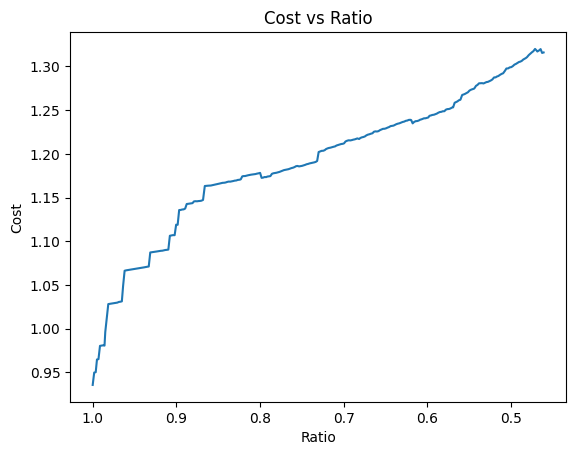

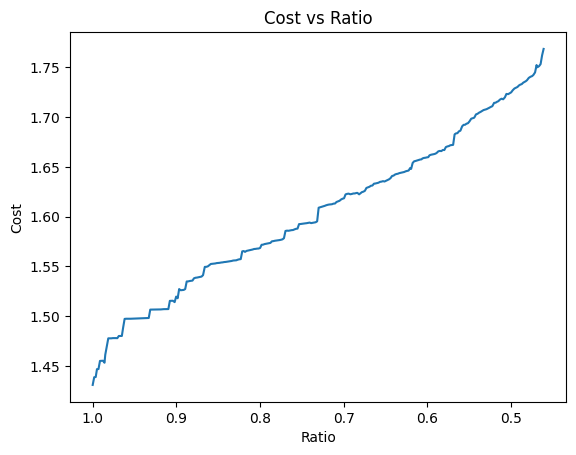

In [26]:
import matplotlib.pyplot as plt
import torch

ratios = coarsener.metrics['r']
costs = [v.cpu() for v in coarsener.metrics['costs_neigh']['cites']][:-1]

plt.plot(ratios, costs)
plt.gca().invert_xaxis()  # Reverse the x-axis: start from 1 down to 0
plt.xlabel("Ratio")
plt.ylabel("Cost")
plt.title("Cost vs Ratio")
plt.show()

import matplotlib.pyplot as plt
import torch

ratios = coarsener.metrics['r']
costs = [v.cpu() for v in coarsener.metrics['costs_h']['cites']][:-1]

plt.plot(ratios, costs)
plt.gca().invert_xaxis()  # Reverse the x-axis: start from 1 down to 0
plt.xlabel("Ratio")
plt.ylabel("Cost")
plt.title("Cost vs Ratio")
plt.show()


In [30]:
import pickle
with open(f'results/cit_cl_pca_10/0.5', 'rb') as fh:
        
    coarsener = pickle.load(fh) 

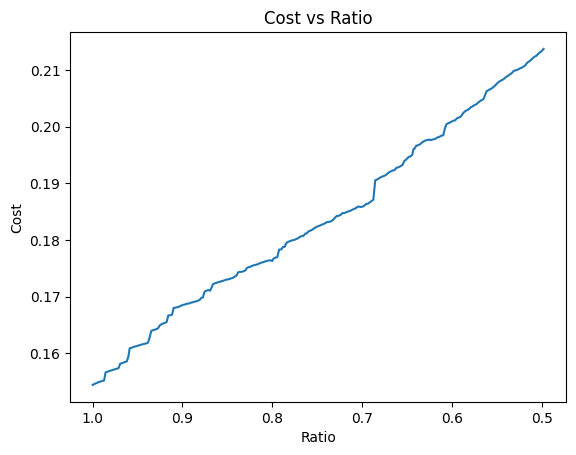

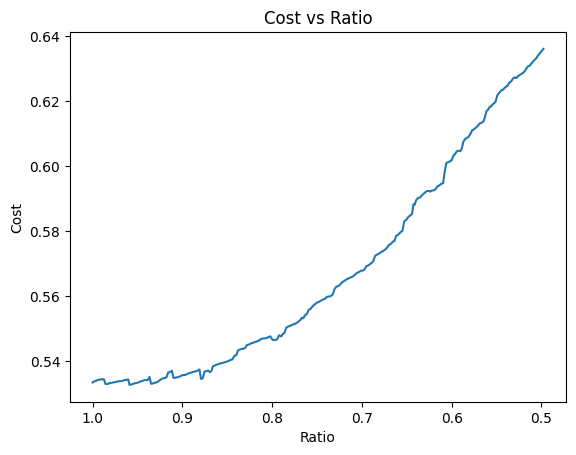

In [31]:
import matplotlib.pyplot as plt
import torch

ratios = coarsener.metrics['r']
costs = [v.cpu() for v in coarsener.metrics['costs_neigh']['cites']]

plt.plot(ratios, costs)
plt.gca().invert_xaxis()  # Reverse the x-axis: start from 1 down to 0
plt.xlabel("Ratio")
plt.ylabel("Cost")
plt.title("Cost vs Ratio")
plt.show()

import matplotlib.pyplot as plt
import torch

ratios = coarsener.metrics['r']
costs = [v.cpu() for v in coarsener.metrics['costs_h']['cites']]

plt.plot(ratios, costs)
plt.gca().invert_xaxis()  # Reverse the x-axis: start from 1 down to 0
plt.xlabel("Ratio")
plt.ylabel("Cost")
plt.title("Cost vs Ratio")
plt.show()


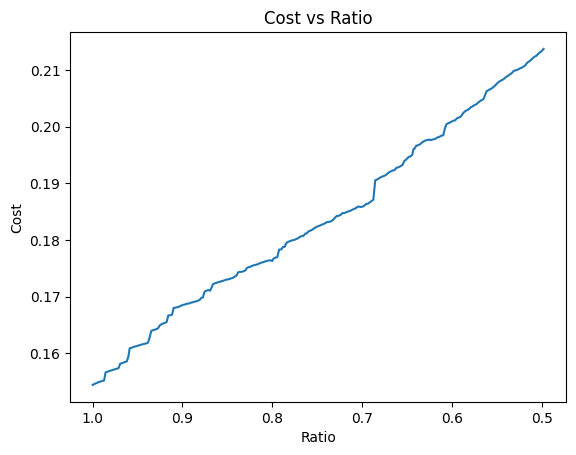

In [12]:
import matplotlib.pyplot as plt
import torch

ratios = coarsener.metrics['r']
costs = [v.cpu()  for v in coarsener.metrics['costs_neigh']['cites']]

plt.plot(ratios, costs)
plt.gca().invert_xaxis()  # Reverse the x-axis: start from 1 down to 0
plt.xlabel("Ratio")
plt.ylabel("Cost")
plt.title("Cost vs Ratio")
plt.show()


In [ ]:
import pickle
with open(f'results/cit_cl_pca_10/0.5', 'rb') as fh:
        
    coarsener = pickle.load(fh) 

/home/robin/thesis/hetero-conv-matching/.venv/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b

In [5]:
coarsend_graph = coarsener.summarized_graph
mapping = coarsener.get_mapping("paper")
#coarsener.make_mask(mapping, "paper")
labels = coarsener.get_labels( mapping, "paper")

coarsend_graph.nodes["paper"].data["label"] = torch.tensor([labels[i] for i in range(len(labels))], device=device)
print("ratio", coarsend_graph.num_nodes()/ original_graph.num_nodes() )    


ratio 0.09948902915539524


In [6]:
original_graph

Graph(num_nodes=3327, num_edges=9228,
      ndata_schemes={'feat': Scheme(shape=(3703,), dtype=torch.float32), 'feat_pca': Scheme(shape=(10,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64), 'train_mask': Scheme(shape=(), dtype=torch.bool), 'val_mask': Scheme(shape=(), dtype=torch.bool), 'test_mask': Scheme(shape=(), dtype=torch.bool)}
      edata_schemes={})

In [7]:
degrees = original_graph.in_degrees()  # or g.out_degrees() for undirected graphs
average_degree = degrees.float().mean().item()
print("Average degree:", average_degree)

Average degree: 2.773669958114624


In [5]:
coarsend_graph

Graph(num_nodes=327, num_edges=2225,
      ndata_schemes={'feat': Scheme(shape=(3703,), dtype=torch.float32), 'feat_pca': Scheme(shape=(10,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64), 'train_mask': Scheme(shape=(), dtype=torch.bool), 'val_mask': Scheme(shape=(), dtype=torch.bool), 'test_mask': Scheme(shape=(), dtype=torch.bool), 'node_size': Scheme(shape=(), dtype=torch.float32), 'deg_cites': Scheme(shape=(), dtype=torch.float32), 'SGCcites': Scheme(shape=(10,), dtype=torch.float32), 'icites': Scheme(shape=(), dtype=torch.float32), 'scites': Scheme(shape=(10,), dtype=torch.float32), 'hcites': Scheme(shape=(10,), dtype=torch.float32)}
      edata_schemes={'adj': Scheme(shape=(), dtype=torch.float32)})

In [8]:
degrees = coarsend_graph.in_degrees()  # or g.out_degrees() for undirected graphs
average_degree = degrees.float().mean().item()
print("Average degree:", average_degree)

Average degree: 6.804281711578369


In [ ]:
#torch.max(coarsend_graph.nodes["paper"].data["feat_pca"])

#coarsend_graph_2 = coarsend_graph
#coarsend_graph_2.nodes["paper"].data["feat"] = coarsend_graph_2.nodes["paper"].data["feat_pca"]

In [30]:
coarsend_graph = coarsend_graph.remove_self_loop()
original_graph = original_graph.remove_self_loop()

In [6]:
coarsend_graph = coarsend_graph.add_self_loop()

original_graph = original_graph.add_self_loop()


In [9]:
import importlib
import Models.SimpleHeteroGCN
importlib.reload(Models.SimpleHeteroGCN)
from Models.SimpleHeteroGCN import HeteroGCNCiteer, HeteroGCNCiteerDropout   , HeteroGCNCiteerCrazy 
from Models.ImprovedGCN import ImprovedGCN
from Experiments.model_helper import run_experiments
orig, coar, loss_ori, loss_coar , _ , _= run_experiments( original_graph, coarsend_graph, HeteroGCNCiteer, num_runs=1, 
                                                  target_node_type="paper", epochs=100,eval_interval=1, model_param={"hidden_dim": 256},
                    )
orig_short = [ o[-1] for o in orig ]
coar_short = [ o[-1] for o in coar ]


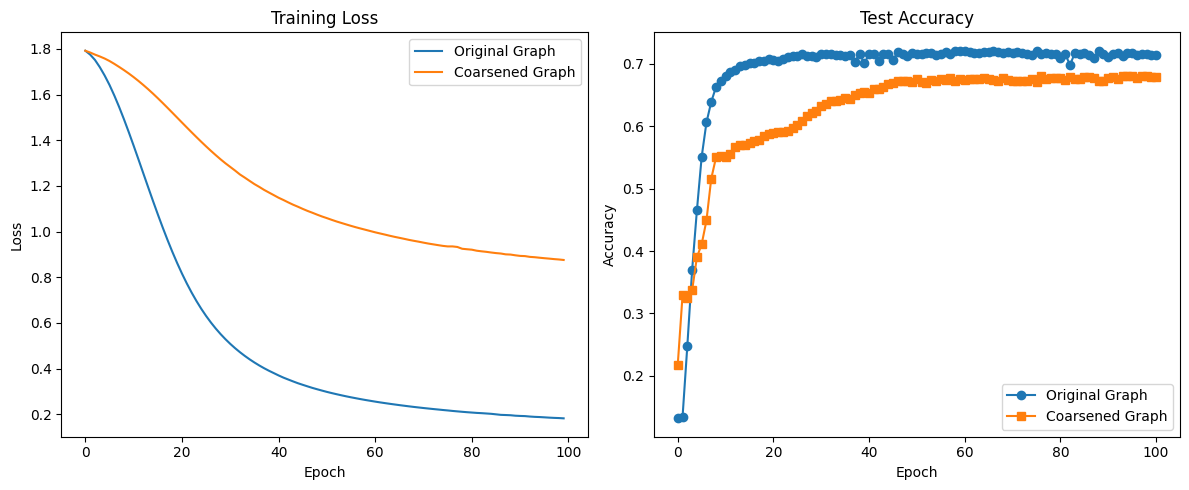

Final Performance Comparison:
Original Graph Accuracy: 0.7140
Coarsened Graph Accuracy: 0.6790

Original Graph Accuracy:
  Mean: 0.7140
  Std:  0.0000

Coarsened Graph Accuracy:
  Mean: 0.6790
  Std:  0.0000


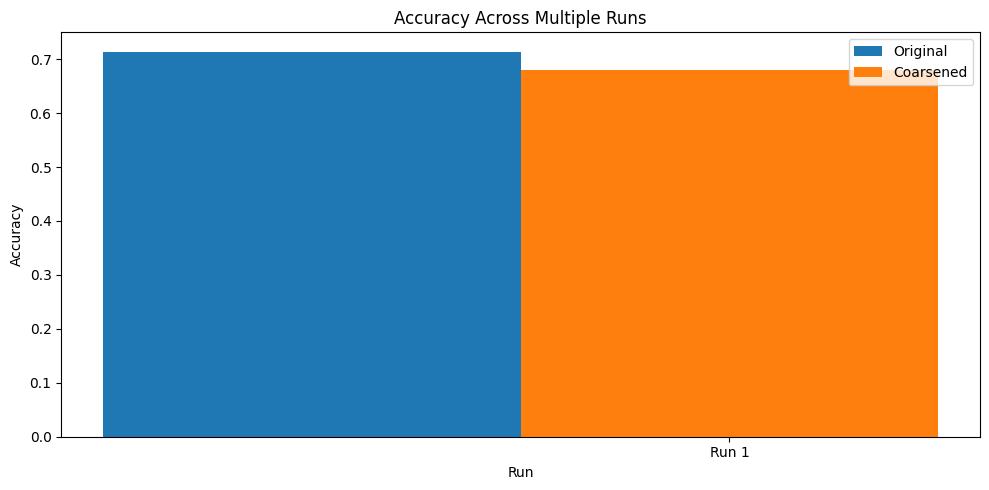

In [10]:
from Experiments.plots import plot_bar, plot_line

epochs = list(range(100))
plot_line(orig[0], coar[0], loss_ori[0], loss_coar[0], epochs)
plot_bar(orig_short, coar_short)

In [ ]:
"""
Relational GCN Network (RGCN).
Paper: https://arxiv.org/abs/1703.06103
"""

import dgl
import torch
import tqdm

from typing import Union, List


class GCNLayer(torch.nn.Module):
    def __init__(self, in_sizes: dict, out_sizes: dict, activation: bool = True,
                 use_layer_norm: bool = True, use_edge_weights: bool = True):
        """
        A single GCN layer.
        :param in_sizes: A dictionary of the dimensions of the input node representation for each node type.
        :param out_sizes: A dictionary of the dimensions of the output node representation for each node type.
        :param canonical_e_types: A list of edge / relation types in the graph.
        :param activation: A boolean representing whether to use an activation function on the output.
        :param use_layer_norm: A boolean representing whether to use layer normalization.
        :param use_edge_weights: A boolean representing whether the edge weights should be used during training.
        """
        super(GCNLayer, self).__init__()

        self.use_edge_weights = use_edge_weights

        activation_layer = torch.nn.Sequential(
            torch.nn.Identity()
        )

        if use_layer_norm:
            activation_layer.append(torch.nn.LayerNorm(out_sizes["_N"]))

        if activation:
            activation_layer.append(torch.nn.ReLU())

        if self.use_edge_weights:
            self.conv = dgl.nn.pytorch.GraphConv(in_sizes["_N"], out_sizes["_N"],
                                                 norm='none', activation=activation_layer)
        else:
            self.conv = dgl.nn.pytorch.GraphConv(in_sizes["_N"], out_sizes["_N"],
                                                 activation=activation_layer)

    def forward(self, graph: dgl.DGLGraph, h: torch.Tensor):
        """
        Perform a feed forward pass with the layer parameters.
        :param graph: A DGLGraph containing the graph structure.
        :param h: A dictionary mapping graph nodes to their associated initial representations.
        :return: The updated node feature dictionary mapping nodes to their output representation.
        """
        if self.use_edge_weights:
            return self.conv(graph, h, edge_weight=graph.edata["normalized_edge_weight"])
        else:
            return self.conv(graph, h)


class MLPInputLayer(torch.nn.Module):
    def __init__(self, h_feats: int, hidden_layer_size: int, use_layer_norm: bool):
        super().__init__()
        self.W1 = torch.nn.Linear(h_feats, hidden_layer_size)
        self.W2 = torch.nn.Linear(hidden_layer_size, hidden_layer_size)

        self.output_layer = torch.nn.Identity()
        if use_layer_norm:
            self.output_layer = torch.nn.LayerNorm(hidden_layer_size)

    def forward(self, h: torch.tensor):
        return self.output_layer(self.W2(torch.nn.functional.relu(self.W1(h))).squeeze(1))


class GCN(torch.nn.Module):
    def __init__(self, graph: dgl.DGLGraph,
                 input_sizes: dict, out_sizes: Union[dict, int],
                 dropout: float, use_edge_weights: bool,
                 use_input_layer: bool, use_layer_norm: bool,
                 hidden_layer_sizes: Union[dict, int],
                 n_layers: int, softmax_output: bool = False,
                 log_softmax: bool = False):
        """
        A GCN network.
        :param graph: A DGLGraph containing the graph structure.
        :param input_sizes: A dictionary of the dimensions of the input node representation for each node type.
        :param out_sizes: A dictionary of the dimensions of the output node representation for each node type.
        :param dropout: A float setting the dropout rate during training.
        :param use_edge_weights: A boolean representing whether the edge weights should be used during training.
        :param use_layer_norm: A boolean representing whether to use layer normalization.
        :param use_input_layer: A boolean representing whether we should use an MLP input layer.
        :param hidden_layer_sizes: A dictionary of the dimensions of the hidden node representation for each node type.
        :param n_layers: The number of layers. Must be greater than 0.
        """
        super(GCN, self).__init__()

        assert n_layers >= 1

        self.softmax_output = softmax_output
        self.log_softmax = log_softmax

        self.dropout = dropout

        if isinstance(hidden_layer_sizes, int):
            self.hidden_layer_sizes_dict = {node_type: hidden_layer_sizes for node_type in graph.ntypes}
        else:
            self.hidden_layer_sizes_dict = hidden_layer_sizes

        if isinstance(out_sizes, int):
            self.out_sizes_dict = {node_type: out_sizes for node_type in graph.ntypes}
        else:
            self.out_sizes_dict = out_sizes

        self.use_input_layer = use_input_layer
        self.input_layer = None
        if self.use_input_layer:
            self.input_layer = MLPInputLayer(input_sizes["_N"], input_sizes["_N"], use_layer_norm)

        # GNN architecture
        self.n_layers = n_layers
        self.layers = torch.nn.ModuleList()

        if self.n_layers > 1:
            # GNN Input layer
            self.layers.append(GCNLayer(input_sizes, self.hidden_layer_sizes_dict,
                                        activation=True, use_layer_norm=use_layer_norm,
                                        use_edge_weights=use_edge_weights))

            # GNN Hidden layers
            for i in range(1, self.n_layers - 1):
                self.layers.append(GCNLayer(self.hidden_layer_sizes_dict, self.hidden_layer_sizes_dict,
                                            activation=True, use_layer_norm=use_layer_norm,
                                            use_edge_weights=use_edge_weights))

            # GNN Output layer
            self.layers.append(GCNLayer(self.hidden_layer_sizes_dict, self.out_sizes_dict,
                                        activation=False, use_layer_norm=use_layer_norm,
                                        use_edge_weights=use_edge_weights))
        else:
            # GNN Input layer
            self.layers.append(GCNLayer(input_sizes, self.out_sizes_dict,
                                        activation=False, use_layer_norm=use_layer_norm,
                                        use_edge_weights=use_edge_weights))

    def forward(self, mfgs: List[dgl.DGLGraph], x: dict, out_key: str):
        """
        Perform a feedforward pass with the GNN on the provided graph to obtain a single node's output representation.
        :param mfgs: The message flow graphs for each layer.
        :param x: The input features of the nodes used in the first layer.
        :param out_key: The node the feedforward pass is obtaining a representation for.
        :return: The output representation of the specified node types.
        """
        x_transformed = x["_N"]
        if self.use_input_layer:
            x_transformed = torch.nn.functional.dropout(
                self.input_layer(x_transformed),
                p=self.dropout, training=self.training)

        # GNN Input layer
        h = self.layers[0](mfgs[0], x_transformed)

        if self.n_layers > 1:
            h = torch.nn.functional.dropout(h, p=self.dropout, training=self.training)

            # GNN Hidden layers
            for i in range(1, self.n_layers - 1):
                h = self.layers[i](mfgs[i], h)
                h = torch.nn.functional.dropout(h, p=self.dropout, training=self.training)

            # GNN Output layer
            h = self.layers[self.n_layers - 1](mfgs[self.n_layers - 1], h)
        if self.log_softmax:
            return torch.nn.functional.log_softmax(h, dim=1)
        elif self.softmax_output:
            return torch.nn.functional.softmax(h, dim=1)
        else:
            return h

    def inference(self, graph: dgl.DGLGraph, x: dict, indices: torch.tensor, device: torch.device, out_key: str):
        """
        Perform exact offline inference with this module.
        :param graph: A DGLGraph containing the graph structure.
        :param x: The input features of all the nodes.
        :param indices: The indices of the nodes to obtain an output representation for.
        :param device: The device to use for batched computations.
        :param out_key: The node type the feedforward pass is obtaining a representation for.
        :return: The output representation of the specified node types.
        """
        n_layer_sampler = dgl.dataloading.MultiLayerFullNeighborSampler(num_layers=self.n_layers)
        dataloader = dgl.dataloading.DataLoader(
            graph, {out_key: indices}, n_layer_sampler,
            device="cpu", batch_size=indices.shape[0], shuffle=False,
            use_prefetch_thread=False, drop_last=False)

        # Compute representations layer by layer
        for i, layer in enumerate(self.layers):
            y = {node_type: torch.zeros(graph.number_of_nodes(node_type),
                                        self.hidden_layer_sizes_dict[node_type] if i != self.n_layers - 1
                                        else self.out_sizes_dict[node_type], device="cpu")
                 for node_type in graph.ntypes}

            # Within a layer, iterate over nodes in batches.
            for _, _, mfgs in tqdm.tqdm(dataloader, "Full Inference. Layer: {}".format(i), leave=False):
                step_size = 128 * 1024
                for start_idx in tqdm.tqdm(range(0, mfgs[i].number_of_dst_nodes(), step_size), "Internal inference batches", leave=False):
                    mfg_indices = (start_idx, min(start_idx + step_size, mfgs[i].number_of_dst_nodes()))
                    dst_node_indices = mfgs[i].dstnodes["_N"].data["_ID"][mfg_indices[0]: mfg_indices[1]]

                    one_layer_sampler = dgl.dataloading.MultiLayerFullNeighborSampler(num_layers=1)
                    one_layer_dataloader = dgl.dataloading.DataLoader(
                        graph, {out_key: dst_node_indices}, one_layer_sampler,
                        device=device, batch_size=step_size, shuffle=False,
                        use_prefetch_thread=False, drop_last=False)

                    for _, _, blocks in one_layer_dataloader:
                        block = blocks[0]

                        # Copy the node representations that are needed for the layer to device.
                        h = x["_N"].to(device)[block.srcnodes["_N"].data["_ID"].to(device)]

                        if self.use_input_layer and (i == 0):
                            h = torch.nn.functional.dropout(self.input_layer(h), p=self.dropout, training=self.training)

                        h = torch.nn.functional.dropout(layer(block, h), p=self.dropout, training=self.training)

                        # Copy output back to CPU.
                        for node_type in block.ntypes:
                            y[node_type][block.dstnodes[node_type].data["_ID"]] = h.cpu()

            x = y

        if self.log_softmax:
            return torch.nn.functional.log_softmax(y[out_key][indices], dim=1)
        elif self.softmax_output:
            return torch.nn.functional.softmax(y[out_key][indices], dim=1)
        else:
            return y[out_key][indices]

def add_norm_edge_weights(g):
    # Compute degree
    degs = g.in_degrees().float()
    norm = torch.pow(degs, -0.5)
    norm[torch.isinf(norm)] = 0
    g.ndata['norm'] = norm

    # Assign edge weight as norm(u) * norm(v)
    g.apply_edges(lambda edges: {'normalized_edge_weight': edges.src['norm'] * edges.dst['norm']})
    return g


import dgl
from dgl.data import CiteseerGraphDataset

dataset = CiteseerGraphDataset()
graph = dataset[0]
graph = graph.to(device)
#graph = dgl.remove_self_loop(graph)
#graph = dgl.add_self_loop(graph)
graph = add_norm_edge_weights(graph)

features = graph.ndata['feat']
labels = graph.ndata['label']
in_feats = features.shape[1]
n_classes = dataset.num_classes

input_sizes = {"_N": in_feats}
hidden_sizes = {"_N": 256}  # you can change the hidden size
output_sizes = {"_N": n_classes}
x_dict = {"_N": features}
model = GCN(
    graph=graph,
    input_sizes=input_sizes,
    out_sizes=output_sizes,
    dropout=0.5,
    use_edge_weights=False,
    use_input_layer=False,
    use_layer_norm=False,
    hidden_layer_sizes=hidden_sizes,
    n_layers=2,  # you can try 1 or more
    softmax_output=False,
    log_softmax=True  # good for classification
)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=5e-4)
loss_fn = torch.nn.NLLLoss()  # because we're using log_softmax

features = graph.ndata['feat']
labels = graph.ndata['label']
train_mask = graph.ndata['train_mask']
val_mask = graph.ndata['val_mask']
test_mask = graph.ndata['test_mask']

x = {"_N": features}
out_key = "_N"

for epoch in range(1000):
    model.train()
    logits = model([graph] * model.n_layers, x, out_key)
    loss = loss_fn(logits[train_mask], labels[train_mask])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    acc = (logits[val_mask].argmax(1) == labels[val_mask]).float().mean()
    print(f"Epoch {epoch:03d} | Loss: {loss.item():.4f} | Val Acc: {acc:.4f}")



